# 02 - Feature Extraction

**Goal:** Extract high-level feature representations from CIFAR-10 using pretrained ResNet50

## Overview
In this notebook, we will:
1. Load the full CIFAR-10 dataset
2. Extract 2048-dimensional features using ResNet50
3. Apply PCA to reduce dimensionality to 50D
4. Visualize the reduced feature space
5. Save features for TDA analysis

**Why Feature Extraction?**
- Raw pixels (32×32×3 = 3,072 dims) are noisy and high-dimensional
- ResNet50 learns semantic features (objects, textures, shapes)
- These features are better suited for TDA

### Setup and Imports

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.manifold import TSNE

# Our modules
from src.data.cifar10 import load_cifar10
from src.models.feature_extractor import FeatureExtractor, DimensionalityReducer

### Load the CIFAR-10 Dataset

We'll use a subset of 5,000 training samples for faster experimentation. For the final paper, we'll scale up to the full 45,000 training samples.

You can test with any number of training samples you like by changing the `5000` to a different number.

In [3]:
(training_images, training_labels), (validation_images, validation_labels), (testing_images, testing_labels), class_names = load_cifar10()

training_images_subset = training_images[:5000]   # 5000 images for quick experiment
training_labels_subset = training_labels[:5000]   # 5000 labels for quick experiment

print(f"\nUsing {len(training_images_subset):,} training samples for feature extraction")


Final splits:
Training:   45000 samples
Validation: 5000 samples
Testing:    10000 samples

Using 5,000 training samples for feature extraction


### Initialize Feature Extractor

We'll use **ResNet50** pretrained on ImageNet:
- **2048-dimensional** feature vectors
- Captures high-level semantic information

In [4]:
extractor = FeatureExtractor(model_name='resnet50')   # Initialize the extractor

2025-11-29 22:21:52.767352: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-29 22:21:52.768495: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-29 22:21:52.768501: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-29 22:21:52.769152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-29 22:21:52.769987: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Model: resnet50
Feature dimension: 2048
Total parameters: 23,587,712


### Extract Features from Training Set

This step processes each image through ResNet50 to extract feature vectors.  
**Expected time:** ~2-3 minutes for 5,000 images on CPU

In [6]:
clean_features = extractor.extract_features(
    training_images_subset, 
    batch_size=64,
    resize_to=224,
    verbose=True
)

print(f"\nFeature extraction complete")


Feature extraction in progress... : 100%|██████████| 79/79 [02:02<00:00,  1.55s/batch]


Extracted features from 5,000 images
Feature shape: (5000, 2048)
Feature range: [0.000, 17.504]

Feature extraction complete


### Feature Statistics

Let's analyze the extracted features before dimensionality reduction:

In [8]:
print(f"Shape: {clean_features.shape}")
print(f"{clean_features.shape[0]:,} samples x {clean_features.shape[1]:,} dimensions")

print(f"\nValue Range:")
print(f"Min:    {clean_features.min():.4f}")
print(f"Max:    {clean_features.max():.4f}")
print(f"Mean:   {clean_features.mean():.4f}")
print(f"Std:    {clean_features.std():.4f}")

print(f"\nSparsity:")
zero_ratio = (clean_features == 0).sum() / clean_features.size
print(f"{zero_ratio:.2%} of feature values are exactly zero")

Shape: (5000, 2048)
5,000 samples x 2,048 dimensions

Value Range:
Min:    0.0000
Max:    17.5043
Mean:   0.0910
Std:    0.6063

Sparsity:
78.00% of feature values are exactly zero


These numbers have no natural units; they represent activation strength. We can think of each number like a score:
- 0 → this feature wasn’t present
- 17.5043 → this feature appeared strongly
- 0.09 mean → most features are weakly activated on average
- std 0.606 → most values cluster < 1, a few rare spikes go higher

Each feature is a completely different concept, so its scale doesn’t matter relative to another feature. What actually matters is:
- Patterns across **ALL** 2048 numbers
- Which features activate together
- How feature vectors cluster in space

That’s why **PCA** is useful since it captures the geometry of these activation patterns.

### Apply PCA Dimensionality Reduction

**Why reduce dimensions?**
- 2048 dimensions is computationally expensive for TDA
- However, 50 dimensions is fast while also preserving approximately 95% of variance
- Removes noise and redundant information

In [ ]:
reducer = DimensionalityReducer(n_components=50, random_state=111)             # PCA reducer
clean_features_reduced = reducer.fit_transform(clean_features, verbose=True)   # Fit and transform features

print(f"PCA dimensionality reduction complete")
print(f"Original: {clean_features.shape}")
print(f"Reduced:  {clean_features_reduced.shape}")


Applying PCA...
Original feature dimension: 2048
Target dimension: 50

PCA dimensionality reduction complete
Original: (5000, 2048)
Reduced:  (5000, 50)


### Visualize Variance Explained by PCA

Let's plot how much information each principal component captures:

Saved variance plot to: ../results/figures/02_pca_variance.png


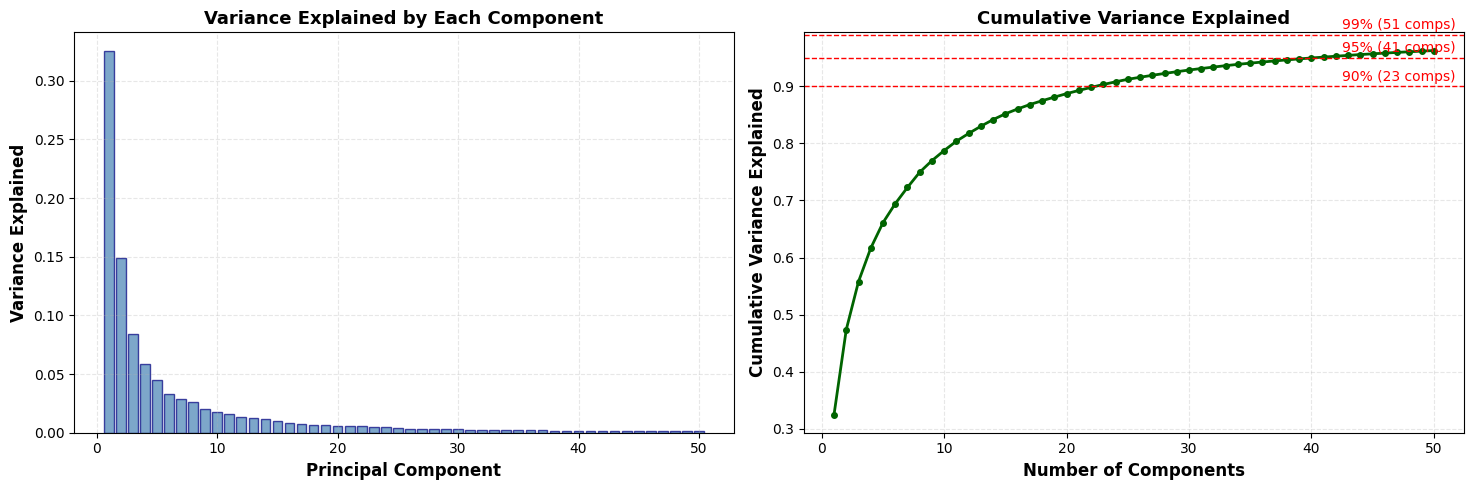

In [10]:
reducer.plot_variance_explained(save_path='../results/figures/02_pca_variance.png')   # Variance explained

### Visualize Reduced Feature Space (2D Projection using t-SNE)

Let's use t-SNE to project 50D features to 2D for visualization.  
**Note:** This is just for visualization; we'll use 50D features for TDA.

In [12]:
tsne = TSNE(n_components=2, perplexity=30, random_state=111)
features_2d = tsne.fit_transform(clean_features_reduced)

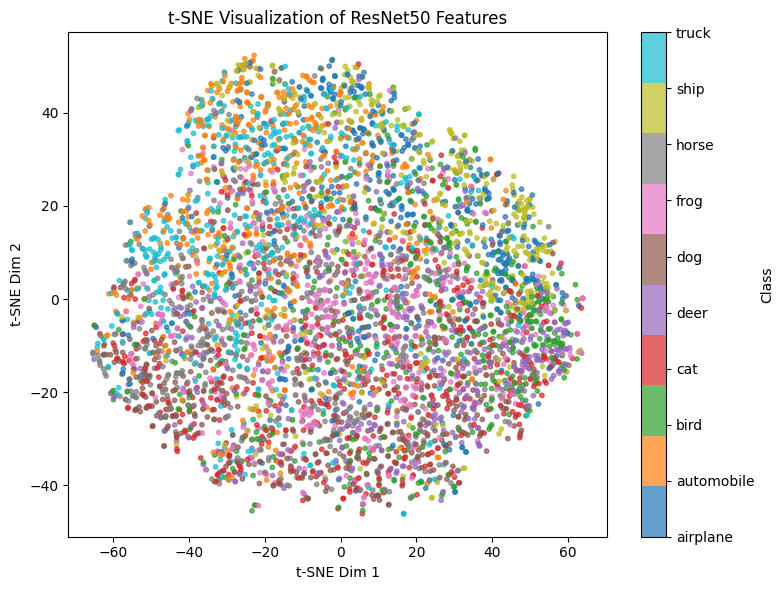

Saved in results/figures/02_tsne_visualization.png


In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
labels_tsne = training_labels[:features_2d.shape[0]]

scatter = ax.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=labels_tsne,
    cmap='tab10',
    s=10,
    alpha=0.7
)

# Colorbar with class names
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Class")
cbar.set_ticks(range(len(class_names)))
cbar.set_ticklabels(class_names)

ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_title("t-SNE Visualization of ResNet50 Features")

plt.tight_layout()
plt.savefig('../results/figures/02_tsne_visualization.png', dpi=150)
plt.show()

print("Saved in results/figures/02_tsne_visualization.png")


**In the plot:**
- Each point is one CIFAR-10 image represented in 2D using t-SNE
- Colors represent class labels (airplane, automobile, bird, etc)
- The 2048-dimensional ResNet50 features were reduced to 50 dimensions (PCA), nd then to 2 dimensions (t-SNE)

**Plot conclusions:**
- Although not perfect, similar classes tend to be near each other: birds near airplanes, trucks near automobiles, cats near dogs, and horses near deer. **Images that look similar appear close together**
- A lot of overlaps:
    - Animals share textures and shapes → overlapping regions
    - Vehicles share edges, metallic textures → another overlapping region